### Setup all the functions required

In [12]:
import sys
import logging
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.cloud import bigquery
from collections import defaultdict
import matplotlib.pyplot as plt

client = bigquery.Client()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)


def batch_commits_and_sum_build_times(
    commits: pd.DataFrame, workflow_runs: pd.DataFrame, batch_max_wait_time: int
):
    """
    Given a DataFrame of commits, batch them into groups based on the time between commits
    """
    total_build_time = 0
    total_batches = 0
    total_delay = 0
    current_batch_workflows = defaultdict(list)
    current_batch_end_time = commits.iloc[0]["date"] + pd.Timedelta(
        minutes=batch_max_wait_time
    )

    for i in range(len(commits)):
        curr_commit = commits.iloc[i]

        if curr_commit["date"] > current_batch_end_time:
            for _, build_times in current_batch_workflows.items():
                total_build_time += np.mean(build_times)

            current_batch_end_time = curr_commit["date"] + pd.Timedelta(
                minutes=batch_max_wait_time
            )
            current_batch_workflows = defaultdict(list)
            total_delay += batch_max_wait_time
            total_batches += 1

        workflows_for_commit = workflow_runs.loc[
            workflow_runs["head_sha"] == curr_commit["sha"]
        ]
        for _, workflow in workflows_for_commit.iterrows():
            current_batch_workflows[workflow["workflow_id"]].append(
                workflow["build_minutes"]
            )

    # Process the last batch
    for _, build_times in current_batch_workflows.items():
        total_build_time += np.mean(build_times)
    total_delay += batch_max_wait_time
    total_batches += 1

    return (total_build_time, total_delay, total_delay / total_batches)


def run_monte_carlo_simulation(
    all_commits: pd.DataFrame, workflow_runs: pd.DataFrame, iterations: int = 10
):
    simulation_results = []
    for _ in tqdm(range(iterations)):
        bootstrap_sample = all_commits.sample(
            n=1000, replace=True
        ).sort_index()  # retain original sorted order which which started at the earliest commit in range and is ascending by time

        merge_queue_batch_delay = np.random.randint(1, 61)
        build_time, total_delay, mean_delay = batch_commits_and_sum_build_times(
            bootstrap_sample, workflow_runs, merge_queue_batch_delay
        )

        simulation_results.append(
            {
                "merge_queue_batch_delay": merge_queue_batch_delay,
                "total_ci_minutes": build_time,
                "total_delay": total_delay,
                "mean_delay": mean_delay,
            }
        )

    simulation_results_df = pd.DataFrame(simulation_results)

    return simulation_results_df


def run_control(workflow_runs: pd.DataFrame):
    return workflow_runs["build_minutes"].sum()

### Pull the data from BigQuery

In [13]:
query_for_commit_shas = "SELECT sha, commit.committer.date FROM `scientific-glow-417622.beam.commits` ORDER BY commit.committer.date ASC"
query_for_workflow_runs = """
    SELECT
        workflow_run.head_sha,
        workflow_run.name,
        workflow_run.workflow_id,
        workflow_run.run_started_at,
        workflow_run.created_at,
        workflow_run.updated_at,
        TIMESTAMP_DIFF(workflow_run.updated_at, workflow_run.created_at, SECOND) / 60.0 AS build_minutes
    FROM
        `scientific-glow-417622.beam.commits` AS commits
    CROSS JOIN
        `scientific-glow-417622.beam.push_and_schedule_workflows`,
        UNNEST(workflow_runs) AS workflow_run
    WHERE
        commits.sha = workflow_run.head_sha AND workflow_run.event = 'push'
        """
logger.info("Fetching data from BigQuery...")
commits_df = client.query_and_wait(query_for_commit_shas).to_dataframe()
workflow_runs_df = client.query_and_wait(query_for_workflow_runs).to_dataframe()


INFO:__main__:Fetching data from BigQuery...


### Run Control

In [14]:
logger.info("Calculating control Build minutes...")
control_build_minutes = run_control(workflow_runs_df)
logger.info(f"Total Build Time for Control is: {control_build_minutes}")
print(control_build_minutes)

INFO:__main__:Calculating control Build minutes...
INFO:__main__:Total Build Time for Control is: 293286.8
293286.8


### Run Monte Carlo Simulation

In [15]:
logger.info("Running Monte Carlo Simulation...")
simulation_results_df = run_monte_carlo_simulation(
    commits_df, workflow_runs_df, iterations=1000
)
print(simulation_results_df)

INFO:__main__:Running Monte Carlo Simulation...


100%|██████████| 1000/1000 [14:02<00:00,  1.19it/s]

     merge_queue_batch_delay  total_ci_minutes  total_delay  mean_delay
0                         26     180439.849524        12740        26.0
1                         38     169165.861865        16910        38.0
2                         48     158097.115093        20112        48.0
3                         60     144582.484173        23400        60.0
4                         40     170554.454603        18040        40.0
..                       ...               ...          ...         ...
995                       19     159431.782619         9462        19.0
996                       10     158874.053333         5550        10.0
997                       26     169502.210833        12324        26.0
998                       54     161301.572778        21870        54.0
999                       57     156311.266918        22515        57.0

[1000 rows x 4 columns]


### Determine Confidence Interval

In [16]:

# For total ci minutes
ci_lower = np.percentile(simulation_results_df['total_ci_minutes'], 2.5)
ci_upper = np.percentile(simulation_results_df['total_ci_minutes'], 97.5)

# For total delay
delay_lower = np.percentile(simulation_results_df['total_delay'], 2.5)
delay_upper = np.percentile(simulation_results_df['total_delay'], 97.5)

### Plot results

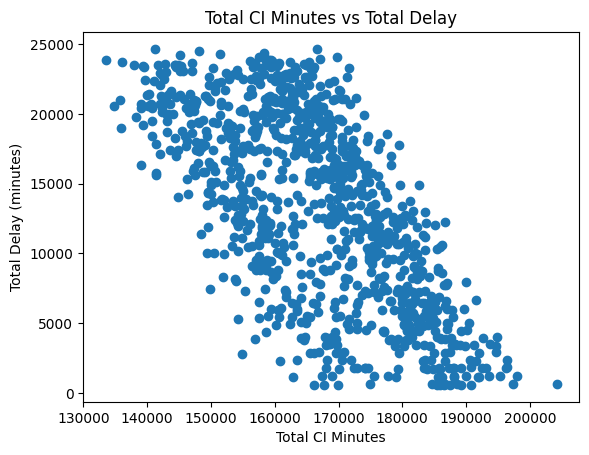

In [17]:
# Plot a scatterplot comparing total_ci_minutes vs total_delay
plt.scatter(
    simulation_results_df["total_ci_minutes"],
    simulation_results_df["total_delay"],
    label="Monte Carlo Simulation Results",
)

plt.xlabel("Total CI Minutes")
plt.ylabel("Total Delay (minutes)")
plt.title("Total CI Minutes vs Total Delay")
plt.show()

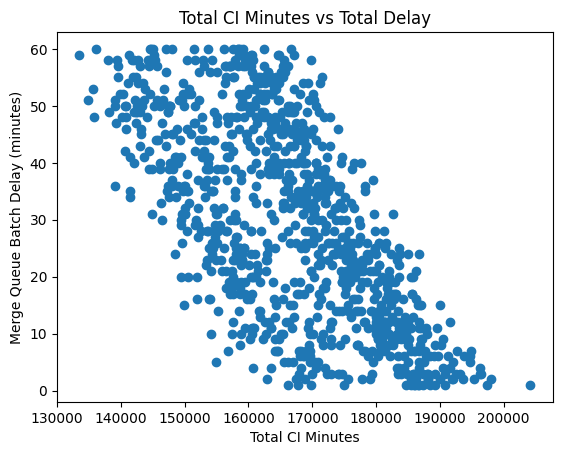

In [18]:
# Plot a scatterplot comparing total_ci_minutes vs total_delay
plt.scatter(
    simulation_results_df["total_ci_minutes"],
    simulation_results_df["merge_queue_batch_delay"],
    label="Monte Carlo Simulation Results",
)

plt.xlabel("Total CI Minutes")
plt.ylabel("Merge Queue Batch Delay (minutes)")
plt.title("Total CI Minutes vs Total Delay")
plt.show()

In [ ]:
from scipy.stats import linregress
# Linear regression
x = simulation_results_df["total_delay"]
y = simulation_results_df["total_ci_minutes"]
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Means for positioning
mean_x = np.mean(x)
mean_y = np.mean(y)

# Calculate the 95% confidence intervals for visualization
ci_x_lower = np.percentile(x, 2.5)
ci_x_upper = np.percentile(x, 97.5)
ci_y_lower = np.percentile(y, 2.5)
ci_y_upper = np.percentile(y, 97.5)

# Regression line values
line_x = np.array([x.min(), x.max()])
line_y = slope * line_x + intercept

# Plot
plt.scatter(x, y, alpha=0.5, label="Monte Carlo Simulation Results")
plt.plot(line_x, line_y, color='red', label='Linear Fit')

# Error bars showing the CI around the mean
plt.errorbar(mean_x, mean_y, 
             xerr=[[mean_x - ci_x_lower], [ci_x_upper - mean_x]],
             yerr=[[mean_y - ci_y_lower], [ci_y_upper - mean_y]],
             fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0, label="Mean with 95% CI")

plt.xlabel("Total Delay (minutes)")
plt.ylabel("Total CI Minutes")
plt.title("Total CI Minutes vs Total Delay with Linear Fit and 95% CI")
plt.legend()
plt.show()